# Comparison of radial convergence profiles

This notebook aims at generating the plot of Millon et al. 2020 (in prep.). The plot shows a comparison of _azimuthally averaged_ convergence profiles for different model families, that were fitted on a set of mock strong lenses.


### Families of model to generate and fit the simulated data
Model families used to __simulate__ the data :
- SPEMD (seeds 211, 212, 219)
- core-SPEMD (seeds 213, 214, 220)
- composite = elliptical Hernquist + NFW (seeds 215, 216, 217, 218, 221)

We used the same model families to __fit__ the data as well. For composite data and models, the Hernquist profile is linked to the light distribution through a constant mass-to-light ratio.


### Official notations
In the paper, for clarity, we use the following model identifiers (all other mock lenses are not published):
- seed 211 $\longrightarrow$ **#1**
- seed 212 $\longrightarrow$ **#2**
- seed 213 $\longrightarrow$ **#3**
- seed 214 $\longrightarrow$ **#4**
- seed 215 $\longrightarrow$ **#5**
- seed 216 $\longrightarrow$ **#6**

### Softwares
This script works with 1.4.0 of `lenstronomy`, and the last version of `TDLMCpipeline`.


### Notes concerning the modelling of #5 and #6 with composite models
After the publication date, a minor discrepency was noticed with the fitted model of lenses #5 and #6, with composite models. In the initial version of the fits, the centroids of the baryonic and dark matter component were (not on purpose) joint in the parameter sampling. These models are in the directories "old_fixMLcentroids" in the data folder, and have been replaced by by new models in the following cells. This notebook now generates the plot with the fixed models. We want to emphasize that the cosmological inference and radial profiles were **not affected** qualitatively by this rectification. Hence all conclusions stated in the paper **remain valid**. This was expected since the mock images were generating with shared mass and light centroids.

In [1]:
# some module imports
import IPython

import os
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from TDLMCpipeline.SimuModelFlexibility.structure import MockStructure
from TDLMCpipeline.Modelling.model_extensions import ModelExtensions
from TDLMCpipeline.Pipeline.io_manager import IOManager
from TDLMCpipeline.Util import util
from TDLMCpipeline.Util import cosmo

%matplotlib inline

fix_core_radius_lenstronomy = True  # previous to lenstronomy v1.4.0, the s_scale parameter of SPEMD_SMOOTH was r_core**2


## Setup truth and models

Here we specify the model identifiers (as in the data folder), and tweak the axis ranges, colors, line styles, etc.

In [2]:
delta_pix = 0.08  # size of pixel in arcsec
r_aperture = 0.5  # radius of the spectroscopic arcsec (for kinematics)
num_pix = 99

base_dir = 'data'

seed_list = range(211, 217)

truth_data = {
    'model_dir': {
        211: 'spemd_true_truetd_recompute_noise_map_191118-165458',
        212: 'spemd_true_truetd_191115-120433',
        213: 'spemd_true_truetd_191115-120519',
        214: 'spemd_true_truetd_191115-134542',
        215: 'truth_mask3pix_gauss-kernel_191125-135102',
        216: 'truth_mask3pix_gauss-kernel_191125-133413',
        217: 'truth_mask3pix_gauss-kernel_191126-142253',
        218: 'truth_mask3pix_gauss-kernel_191126-145359',
    },
    'title': {
        211: "power law #1",
        212: "power law #2",
        213: "cored power law #3",
        214: "cored power law #4",
        215: "composite #5",
        216: "composite #6",
    },
    'label': "truth",
    'plot_kwargs': {'color': 'black', 'linewidth': 3, 'linestyle': ':', 'zorder': 6},
}

model_data = {
    'model_dir_list': {
        211: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-021719',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022359',
            None, #'composite_std-start_no-astrometry_mask3pix_repro-kinem_191128-131653',
        ],
        212: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-021929',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022428',
            None, #'composite_std-start_no-astrometry_mask3pix_repro-kinem_191128-131653',
        ],
        213: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022029',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022631',
            None, #'composite_std-start_no-astrometry_mask3pix_repro-kinem_191128-131653',
        ],
        214: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022059',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022631',
            None, #'composite_std-start_no-astrometry_mask3pix_repro-kinem_191128-131653',
        ],
        215: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022158',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022659 2',
            #'old_fixMLcentroids/composite_std-start_no-astrometry_mask3pix_repro-kinem_191203-222846',  # like in published version
            'composite_no-astrometry_true-delays_from-truth_mask-center_200325-152609',
        ],
        216: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022259',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191204-121318',
            #'old_fixMLcentroids/composite_std-start_no-astrometry_mask3pix_repro-kinem_191203-223109',  # like in published version
            'composite_no-astrometry_true-delays_from-truth_mask-center_200325-152609',
        ],
    },
    'label_list': ["power law", "cored power law", "composite"],
    'color_list': ['#379CD0', '#25AB1F', '#E04F4A', '#888888'],
    'linestyle_list': ['-', '--', '-.', ':'],
    'plot_kwargs': {'linewidth': 2, 'zorder': 4}
}

misc_data = {
    'einstein_radius': {
        'label': "Einstein radius",
        'line_kwargs': {'color': '#888888', 'linewidth': 2, 'linestyle': '--', 'zorder': 3},
    },
    'images_range': {
        'label': "Images range",
        'line_kwargs': {'color': '#AAAAAA', 'linewidth': 2, 'linestyle': '--', 'zorder': 2},
        'span_kwargs': {'color': 'black', 'alpha': 0.1, 'zorder': 1},
    },
    'spectro_aperture': {
        'label': "Spectro. aperture",
        'line_kwargs': {'color': '#888888', 'linewidth': 2, 'linestyle': ':', 'zorder': 1},
    },
    'zero_error': {
        'line_kwargs': {'color': 'black', 'alpha': 0.2, 'linewidth': 1, 'linestyle': '-', 'zorder': 0},
    }
}

axis_limits = {
    'radius': [
        # format : [axis limits, tick locations, labels location]
        (0.09, 3.2),  # arcsec
        [0.1, 0.3, 0.5, 1, 3],  # arcsec
        ["0.1", "0.3", "0.5", "1", "3"],  # arcsec
    ],
    'kappa': {
        211: [(2e-1, 6e0), [3e-1, 1e0, 3e0], ["0.3", "1", "3"]],  # format : [axis limits, tick locations, labels location]
        212: [(2e-1, 6e0), [3e-1, 1e0, 3e0], ["0.3", "1", "3"]],
        213: [(2e-1, 4e0), [3e-1, 1e0, 3e0], ["0.3", "1", "3"]],
        214: [(2e-1, 4e0), [3e-1, 1e0, 3e0], ["0.3", "1", "3"]],
        215: [(2e-1, 4e0), [3e-1, 1e0, 3e0], ["0.3", "1", "3"]],
        216: [(5e-1, 2e0), [6e-1, 1e0, 2e0], ["0.6", "1", "2"]],
    },
    'error': [
        # format : [axis limits, tick locations, labels location]
        (-10, 10), [-10, -5, 0, 5, 10], [r"$-10\%$", "", r"$0$", "", r"$+10\%$"]
    ],
}

## Setup the figure layout

In [3]:
fontsize_general = 16
fontsize_ticklabels = 12
fontsize_text_model = 14
fontsize_text_data = 12
plt.rc('font', size=fontsize_general)
plt.rc('xtick', labelsize=fontsize_ticklabels)
plt.rc('ytick', labelsize=fontsize_ticklabels)
#plt.rc('text', usetex=True)

fig = plt.figure(figsize=(14, 20), constrained_layout=False)
gs = fig.add_gridspec(4, 2, wspace=0.15, hspace=0.3, 
                      width_ratios=[1, 1], height_ratios=[0.05, 1, 1, 1])

ax_legend = fig.add_subplot(gs[0, :])
#ax_legend.text(0.5, 0.5, "[legend placeholder]", ha='center', va='center')
ax_legend.axis('off')

axes_data = {}
row_idx = 1
for s, seed in enumerate(seed_list):
    col_idx = s % 2
    
    # panel 1 : kappa radial profiles
    ax_model = fig.add_subplot(gs[row_idx, col_idx])
    if col_idx == 0:
        ax_model.set_ylabel(r"$\langle\kappa(r)\rangle$")
    
    # panel 2 : error wrt to truth
    divider = make_axes_locatable(ax_model)
    ax_error = divider.append_axes('bottom', pad=0.1, size='25%')
    ax_error.set_xlabel(r"$r$ [arcsec]")
    if col_idx == 0:
        ax_error.set_ylabel("error")
    
    axes_data[seed] = (ax_model, ax_error)
    if col_idx == 1:
        row_idx += 1
        
# UNCOMMENT this to show naked layout
plt.close()

print(axes_data.keys())


dict_keys([211, 212, 213, 214, 215, 216])


## Define functions to retrieve data

Define functions that can load the data, compute quantities and get $H_0$ for a given model directory.

In [4]:
def fix_core_radius_definition(output_data):
    """
    fixes the value of the `s_scale` parameter of the SPEMD profile, 
    due an issue in older versions of lenstronomy.
    This concerns the kwargs_result and the MCMC samples, if any.
    
    WARNING : we assume the following settings:
    - when s_scale is detecte in the parameter list, it is necessarily for SPEMD (cored power-law).
    - the SPEMD is at the first position in the lens profile list.
    """
    # treat the best-fit parameters
    kwargs_result, chain_list = output_data[0], output_data[1]
    for i, kwargs_profile in enumerate(kwargs_result['kwargs_lens']):
        for param_name, param_value in kwargs_profile.items():
            if param_name == 's_scale' and param_value > 1e-4:  # consider no core under a given value
                print(param_value, np.sqrt(param_value))
                kwargs_profile[param_name] = np.sqrt(param_value)  # square root of older value
        kwargs_result['kwargs_lens'][i] = kwargs_profile
    # update container
    output_data[0] = kwargs_result
    # treat the MCMC samples, if any
    if chain_list[-1][0] in ['EMCEE', 'COSMOHAMMER']:
        samples, sample_param_names = chain_list[-1][1], chain_list[-1][2]  # assuming last item is MCMC samples
        try:
            index_s_scale = sample_param_names.index('s_scale_lens0')
        except ValueError:
            pass
        else:
            samples[:, index_s_scale] = np.sqrt(samples[:, index_s_scale])  # square root of older value
            # update container
            chain_list[-1][1] = samples
            output_data[1] = chain_list
    return output_data

def get_radial_quantities_from_model(model_dir):
    """
    Returns some radial quantities for a given TDLMCpipeline model:
    evaluation radii, convergence, lensed images inner/outer radii, Einstein radius.
    """
    # extract data
    input_data_path  = os.path.join(model_dir, 'fit_input_sampling.pkl')
    output_data_path = os.path.join(model_dir, 'fit_output_sampling.pkl')
    input_data, output_data = IOManager.load_fit_data(input_data_path, output_data_path, ensure_compatibility=True)
    if fix_core_radius_lenstronomy:
        output_data = fix_core_radius_definition(output_data)
    model_ext = ModelExtensions(input_data, output_data, bestfit_from_mcmc=False)
    print("BIC best fit : {:.1f}".format(model_ext.BIC_bestfit))
    
    # radial convergence
    r, kappa_r_total = model_ext.convergence_radial_profile()
    
    # AGN image radius range
    r_min, r_max = model_ext.radial_image_position_range()
    
    # Einstein radius
    r_einstein = model_ext.effective_einstein_radius()
    
    return r, kappa_r_total, r_min, r_max, r_einstein

def get_inferred_cosmology(seed, model_dir, from_Ddt_Dd_inference=False, last_num_samples=5000):
    """
    Returns H0 with uncertainties for a given TDLMCpipeline model.
    """
    if from_Ddt_Dd_inference:
        inference_data_path = os.path.join(model_dir, 'infer_kde_output-Ddt_params.pkl')
        H0_post_list, bool_load = IOManager.load_pickle(inference_data_path, verbose=True)
        if not bool_load:
            print("Warning : could not load inference data")
            return np.nan, np.nan, np.nan
        else:
            H0_posterior = H0_post_list[0]
    else:
        mock_structure = MockStructure(seed)
        postpro_path = os.path.join(model_dir, 'postpro_data.pkl')
        postpro_data, bool_load = IOManager.load_pickle(postpro_path, verbose=True)
        Ddt_posterior = postpro_data['param_Ddt']
        if len(Ddt_posterior) > last_num_samples:
            print("Warning : cut Ddt chain to last {} samples".format(last_num_samples))
            Ddt_posterior = Ddt_posterior[-last_num_samples:]
        H0_posterior  = cosmo.Ddt_2_H0(Ddt_posterior, mock_structure.lens.z_lens, mock_structure.lens.z_source, 
                                       mock_structure.cosmo.omega_m, mock_structure.cosmo.omega_l)
    #H0_value, H0_error_neg, H0_error_pos = util.inference_from_distrib(H0_posterior)
    h016, h050, h084 = np.percentile(H0_posterior, [16, 50, 84])
    H0_value, H0_error_neg, H0_error_pos = h050, h050 - h016, h084 - h050
    return H0_value, H0_error_neg, H0_error_pos

def render_H0_text(val, err_minus=None, err_plus=None, unit=False):
    """simply renders H0 string in LaTeX format"""
    if err_minus is None or err_plus is None:
        if unit:
            return r'$%.1f\, \rm{km\,s^{-1}\,Mpc^{-1}}$' % val
        else:
            return r'$%.1f$' % val
    if unit:
        return r'$%.1f_{-%.1f}^{+%.1f}\, \rm{km\,s^{-1}\,Mpc^{-1}}$' \
            % (val, err_minus, err_plus)
    else:
        return r'$H_0 : %.1f_{-%.1f}^{+%.1f}$' % (val, err_minus, err_plus)

## Loop over lenses to plot profiles, errors, texts, ...

For each model in the list specify at the top of the notebook, we compute radial profiles and other properties to display on the plot.

In [5]:
line_list, label_list = [], []
for s, seed in enumerate(seed_list):
    print("{} seed {} {}".format("="*10, seed, "="*10))
    ax_model, ax_error = axes_data[seed]

    # indicate name of the data
    truth_text = "truth: " + truth_data['title'][seed]
    ax_model.text(0.03, 0.05, truth_text, horizontalalignment='left', verticalalignment='bottom',
                  transform=ax_model.transAxes, fontsize=fontsize_text_data, bbox={'facecolor': 'white', 'alpha': 0.7})
    
    # plot aperture location    
    ax_model.axvline(r_aperture, **misc_data['spectro_aperture']['line_kwargs'])
    ax_error.axvline(r_aperture, **misc_data['spectro_aperture']['line_kwargs'])
    
    # get quantities from 'truth' model
    truth_dir = os.path.join(base_dir, 's{}'.format(seed), truth_data['model_dir'][seed])
    r_truth, kappa_r_truth, r_min, r_max, r_einstein = get_radial_quantities_from_model(truth_dir)
    
    # plot the lensed images range
    #ax_model.axvline(r_min, **misc_data['images_range']['line_kwargs'])
    #ax_model.axvline(r_max, **misc_data['images_range']['line_kwargs'])
    ax_model.axvspan(r_min, r_max, **misc_data['images_range']['span_kwargs'])
    ax_error.axvspan(r_min, r_max, **misc_data['images_range']['span_kwargs'])
    
    # plot Einstein ring location
    ax_model.axvline(r_einstein, **misc_data['einstein_radius']['line_kwargs'])
    ax_error.axvline(r_einstein, **misc_data['einstein_radius']['line_kwargs'])
    
    # plot quantities from fitted models
    text_offset = 0
    for m, model_dir_ in enumerate(model_data['model_dir_list'][seed]):
        if model_dir_ is None:
            continue
        print("{} model {} {}".format("-"*5, model_data['label_list'][m], "-"*5))
        
        # get quantities from the fitted model
        model_dir = os.path.join(base_dir, 's{}'.format(seed), model_dir_)
        r_model, kappa_r_model, _, _, _ = get_radial_quantities_from_model(model_dir)
        #print(seed, kappa_r_model.shape, kappa_r_truth.shape)
        
        # because of numerics when compute azimuthally averaged profiles, profiles may not have the same length
        # in those case, only the outer radius is different, so we discard the last values if needed
        min_len = min(len(r_truth), len(r_model))
        if len(r_truth) != min_len:
            r_truth = r_truth[:min_len]
            kappa_r_truth = kappa_r_truth[:min_len]
        elif len(r_model) != min_len:
            r_model = r_model[:min_len]
            kappa_r_model = kappa_r_model[:min_len]
        
        # plot the modelled profile
        line_model, = ax_model.plot(r_model, kappa_r_model, #label=model_data['label_list'][m], 
                                    color=model_data['color_list'][m], linestyle=model_data['linestyle_list'][m],
                                    **model_data['plot_kwargs'])
        
        # indicate H0, BIC, etc...
        H0_value, H0_n, H0_p = get_inferred_cosmology(seed, model_dir, from_Ddt_Dd_inference=False)
        H0_text = render_H0_text(H0_value, H0_n, H0_p, unit=False)
        ax_model.text(0.05, 0.2+text_offset, H0_text, horizontalalignment='left', verticalalignment='bottom',
                      color=model_data['color_list'][m], transform=ax_model.transAxes, fontsize=fontsize_text_model)
        text_offset += 0.15
        
        # compute relative error
        rel_error = (kappa_r_truth-kappa_r_model)/kappa_r_truth
        ax_error.plot(r_model, rel_error * 100., #label=model_data['label_list'][m], 
                      color=model_data['color_list'][m], linestyle=model_data['linestyle_list'][m],
                      **model_data['plot_kwargs'])
        ax_error.axhline(0, **misc_data['zero_error']['line_kwargs'])
        
        # add to legend list
        model_text = "model: " + model_data['label_list'][m]
        if model_text not in label_list:
            label_list.append(model_text)
            line_list.append(line_model)
    
    # plot the true profile
    line_truth, = ax_model.plot(r_truth, kappa_r_truth, #label=truth_data['label'], 
                               **truth_data['plot_kwargs'])
    # add to legend list
    if truth_data['label'] not in label_list:
        label_list.insert(0, truth_data['label'])
        line_list.insert(0, line_truth)
    
    # for some reason, we have to set some limits and ticks/labels *after* the plots
    plot_radius_range, plot_radius_ticks, plot_radius_labels = axis_limits['radius']
    plot_kappa_range, plot_kappa_ticks, plot_kappa_labels = axis_limits['kappa'][seed]
    plot_error_range, plot_error_ticks, plot_error_labels = axis_limits['error']
    
    ax_model.set_xscale('log')
    ax_model.set_xlim(*plot_radius_range)
    ax_model.set_xticks(plot_radius_ticks)
    ax_model.set_xticklabels([""]*len(plot_radius_ticks))
    ax_model.set_yscale('log')
    ax_model.set_ylim(*plot_kappa_range)
    ax_model.set_yticks(plot_kappa_ticks)
    ax_model.set_yticklabels(plot_kappa_labels)
    
    ax_error.set_xscale('log')
    ax_error.set_xlim(*plot_radius_range)
    ax_error.set_xticks(plot_radius_ticks)
    ax_error.set_xticklabels(plot_radius_labels)
    ax_error.set_ylim(*plot_error_range)
    ax_error.set_yticks(plot_error_ticks)
    ax_error.set_yticklabels(plot_error_labels)
    
    ax_model.grid('on', alpha=0.3)
    
# place the legend in the upper pannel
ax_legend, _ = axes_data[seed_list[0]]
ax_legend.legend(handles=line_list, labels=label_list, ncol=4, bbox_to_anchor=(1.07, 1.2), 
                loc='center', frameon=True, borderaxespad=0)

#fig.tight_layout()
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None)

========== seed 211 ==========
BIC best fit : 7505.6
----- model power law -----
BIC best fit : 8910.3
----- model cored power law -----


/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


BIC best fit : 17195.2
========== seed 212 ==========
BIC best fit : 15947.0
----- model power law -----
BIC best fit : 8542.0
----- model cored power law -----
BIC best fit : 6051857.9
========== seed 213 ==========
0.31301 0.5594729662816604
BIC best fit : 15766.4
----- model power law -----
BIC best fit : 16672.6
----- model cored power law -----
0.29925790035983063 0.5470446968574237
BIC best fit : 8537.1
========== seed 214 ==========
0.31427 0.560597895108428
BIC best fit : 16544.5
----- model power law -----
BIC best fit : 24242.3
----- model cored power law -----
0.30546259470367876 0.5526867057417599
BIC best fit : 8526.9
========== seed 215 ==========
BIC best fit : 8297.5
----- model power law -----
BIC best fit : 16711.2
----- model cored power law -----
0.06729869123828908 0.25941991295636707
BIC best fit : 16430.4
----- model composite -----
BIC best fit : 8299.4
========== seed 216 ==========
BIC best fit : 8380.4
----- model power law -----
BIC best fit : 20939.5
----- 

## Display & save figure

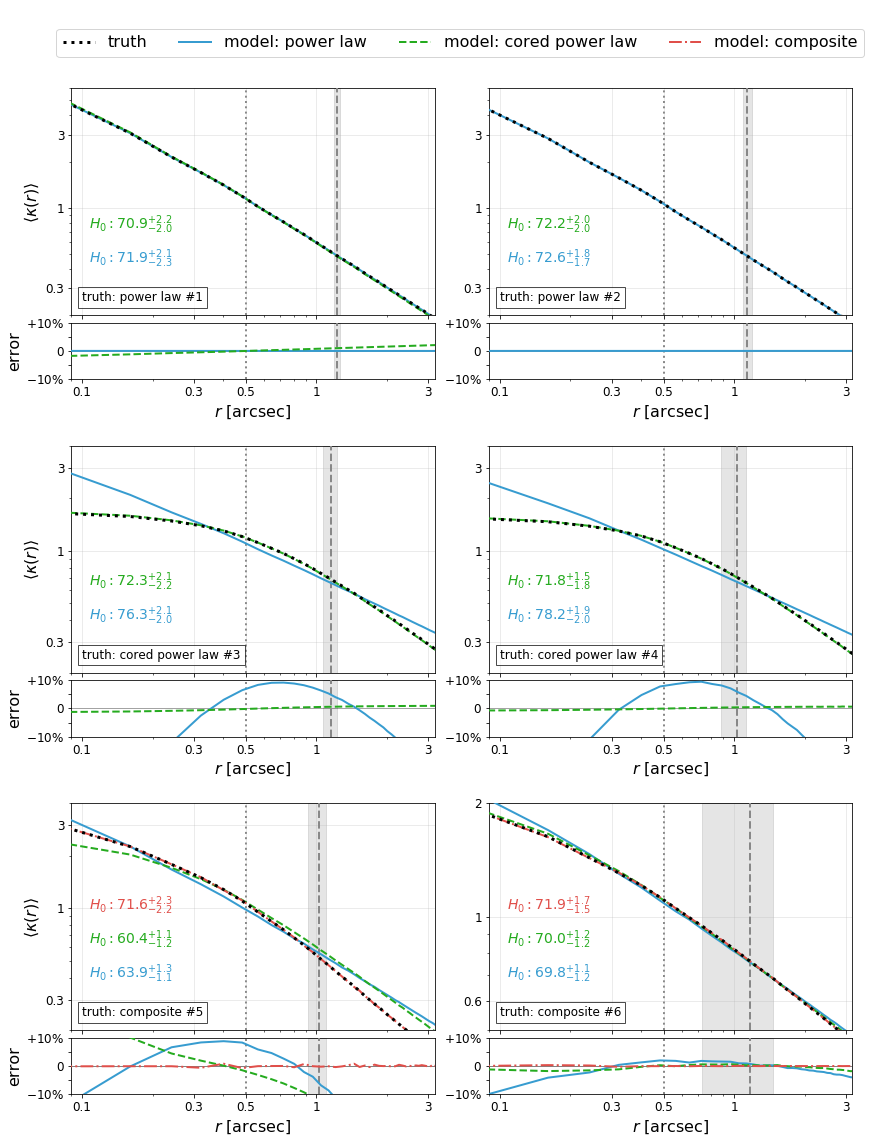

In [6]:
IPython.display.display(fig)
fig.savefig(os.path.join("..", "Figures", "radial_convergence_models.pdf", bbox_inches='tight')